# Credit Card Fraud Detection (part3)
The objective is to identify fraudulent credit card transactions (492 instances) among legitimate transactions (284315 instances). 

In previous notebooks we dealt with the imbalanced class problem by changing the weights in the loss function (so that a misclassified minority class is penalized more than a misclassified majority class) and utilizing over/under sampling methods in the first and second notebooks respectively.

Moreover, please refer to the first notebook for more information about the dataset.

## Step 1: Loading libraries to be used in the modeling and loading the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('numpy version: ',np.__version__)
print('pandas version: ',pd.__version__)
print('seaborn version: ',sns.__version__)

numpy version:  1.18.1
pandas version:  1.0.1
seaborn version:  0.10.0


In [2]:
#loading the data from the csv file downloaded from Kaggle

data = pd.read_csv('datasets/credit-card-fraud.csv', header='infer')

X = data.iloc[:, 0:30]
y = data.loc[:, 'Class']

## Step 2: Splitting the data into training and test sets

In [3]:
#setting the random seed for reproducibility
random_seed = 2020

In [4]:
# I am setting 33.3% data aside for the test set.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, stratify=y, random_state=random_seed)

## Step 3: Reviewing the results of the previous notebook
The following models gave us the best results with respect to average precision in the previous notebook:
* LGBM -- LGBMClassifier with n_estimators=150 and learning_rate=0.2
* ETC_ADA -- Extra Trees Classifier with n_estimators=200 oversampled with ADASYN with n_neighbors=7

Here we will reproduce these results and precision-recall curve for all models to establish a baseline for comparing subsequent models.

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
from imblearn.over_sampling import ADASYN

from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

Using TensorFlow backend.


In [6]:
LGBM = lgb.LGBMClassifier(class_weight='balanced', random_state=random_seed, n_estimators=150, 
                          learning_rate=0.2, n_jobs=-1)
LGBM.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.2,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
               objective=None, random_state=2020, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [7]:
ada = ADASYN(n_neighbors=7, random_state=random_seed, n_jobs=-1)
X_train_ada, y_train_ada = ada.fit_sample(X_train, y_train)

ETC_ADA = ExtraTreesClassifier(n_estimators=200, random_state=random_seed, n_jobs=-1)
ETC_ADA.fit(X_train_ada, y_train_ada)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                     oob_score=False, random_state=2020, verbose=0,
                     warm_start=False)

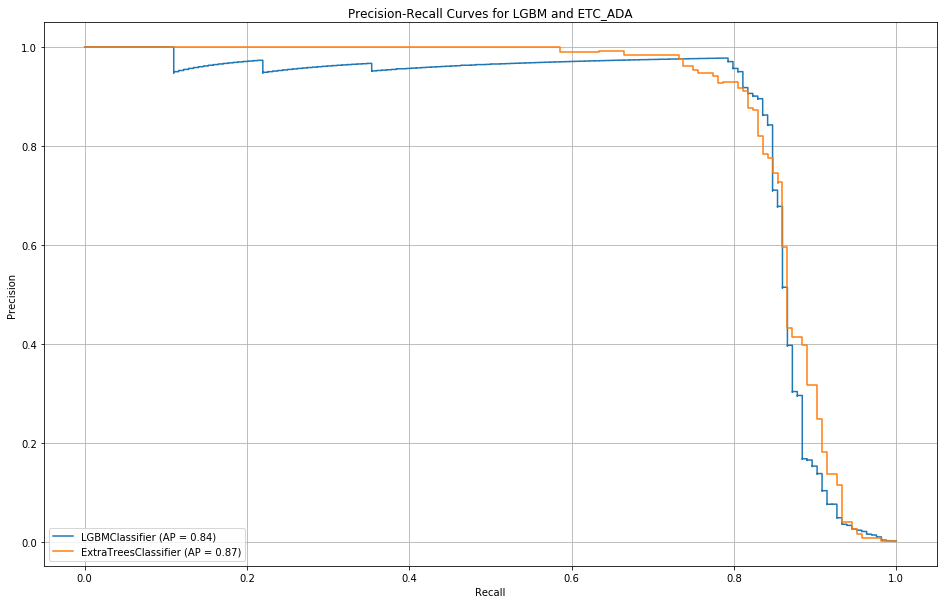

In [8]:
disp_LGBM = plot_precision_recall_curve(LGBM, X_test, y_test)
disp_ETC_ADA = plot_precision_recall_curve(ETC_ADA, X_test, y_test, ax=disp_LGBM.ax_)
disp_LGBM.ax_.set_title('Precision-Recall Curves for LGBM and ETC_ADA')
disp_LGBM.figure_.set_size_inches(16, 10)
plt.grid()
plt.show()

In [9]:
print('LGBM Average Precision = ', np.round(disp_LGBM.average_precision, 5))
print('ETC_ADA Average Precision = ', np.round(disp_ETC_ADA.average_precision, 5))

LGBM Average Precision =  0.84353
ETC_ADA Average Precision =  0.86789


## Step 4: Ensemble methods of imbalanced-learn library

In [10]:
from imblearn.ensemble import (BalancedBaggingClassifier,
                               BalancedRandomForestClassifier,
                               EasyEnsembleClassifier,
                               RUSBoostClassifier)
models = [
    ('bbc', BalancedBaggingClassifier(random_state=random_seed)),
    ('brfc', BalancedRandomForestClassifier(random_state=random_seed)),
    ('eec', EasyEnsembleClassifier(random_state=random_seed)),
    ('rbc', RUSBoostClassifier(random_state=random_seed))
]

In [11]:
from sklearn.model_selection import cross_val_score

cv = 5
scoring = 'average_precision'

In [12]:
cv_results = {}

for name, model in models:
    cv_res = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [13]:
results_df = pd.DataFrame(cv_results, index=range(1, cv+1))

In [14]:
results_df.mean(axis='index').sort_values()

bbc     0.522547
rbc     0.605540
eec     0.715537
brfc    0.737709
dtype: float64

In [15]:
results_df.std(axis='index')

bbc     0.090527
brfc    0.043364
eec     0.083808
rbc     0.090549
dtype: float64

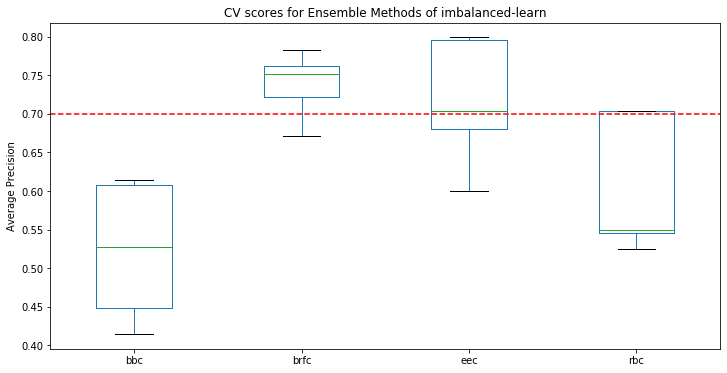

In [16]:
results_df.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for Ensemble Methods of imbalanced-learn')
plt.axhline(y=0.7, color='red', linestyle='dashed')
plt.ylabel('Average Precision')
plt.show()

## Step 4: Fine tuning the models

In [17]:
from sklearn.model_selection import GridSearchCV

### Balanced Bagging Classifier

In [18]:
n_estimators = [100, 200, 400, 600]  #default=10
bootstrap = [True, False]  #default=True
par_grid_bbc = dict(n_estimators=n_estimators, bootstrap=bootstrap)

bbc = BalancedBaggingClassifier(random_state=random_seed)

grid_bbc = GridSearchCV(estimator=bbc, param_grid=par_grid_bbc, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_bbc = grid_bbc.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 12.4min finished


In [19]:
grid_result_bbc.best_params_

{'bootstrap': True, 'n_estimators': 600}

In [20]:
grid_result_bbc.best_score_

0.7731712982981265

In [21]:
pd.DataFrame(grid_result_bbc.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
3,"{'bootstrap': True, 'n_estimators': 600}",0.773171,0.029623,1
2,"{'bootstrap': True, 'n_estimators': 400}",0.762247,0.031620,2
6,"{'bootstrap': False, 'n_estimators': 400}",0.759691,0.037466,3
7,"{'bootstrap': False, 'n_estimators': 600}",0.757185,0.035731,4
5,"{'bootstrap': False, 'n_estimators': 200}",0.751727,0.040905,5
1,"{'bootstrap': True, 'n_estimators': 200}",0.750056,0.035411,6
0,"{'bootstrap': True, 'n_estimators': 100}",0.745859,0.041021,7


#### The best estimator is with n_estimators=600
It is not surprising that we get better results with larger number of estimators in the model. Moreover, n_estimators=600 seems to be the sweet spot in the sense that there is not significant improvement in the score with increased number of estimators.

### Balanced Random Forest Classifier

In [22]:
n_estimators = [100, 200, 400, 600]  #default=100
bootstrap = [True, False]  #default=True
par_grid_brfc = dict(n_estimators=n_estimators, bootstrap=bootstrap)

brfc = BalancedRandomForestClassifier(random_state=random_seed)

grid_brfc = GridSearchCV(estimator=brfc, param_grid=par_grid_brfc, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_brfc = grid_brfc.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.7min finished


In [23]:
grid_result_brfc.best_params_

{'bootstrap': False, 'n_estimators': 600}

In [24]:
grid_result_brfc.best_score_

0.7713567103669683

In [25]:
pd.DataFrame(grid_result_brfc.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
7,"{'bootstrap': False, 'n_estimators': 600}",0.771357,0.034545,1
6,"{'bootstrap': False, 'n_estimators': 400}",0.764609,0.034570,2
2,"{'bootstrap': True, 'n_estimators': 400}",0.756094,0.030381,3
1,"{'bootstrap': True, 'n_estimators': 200}",0.754762,0.033253,4
5,"{'bootstrap': False, 'n_estimators': 200}",0.753386,0.045416,5
3,"{'bootstrap': True, 'n_estimators': 600}",0.751022,0.034336,6
4,"{'bootstrap': False, 'n_estimators': 100}",0.745153,0.042554,7


#### The best estimator is with n_estimators=600 and bootstrap=False
Again, it is not surprising that the larger number of estimators in the model, the better the result is. Similarly, n_estimators=600 seems to be the sweet spot.

### Easy Ensemble Classifier
The default estimator in the Easy Ensemble Classifier is AdaBoost; however, we will also include LGBMClassifier since we tend to get good results with it.

In [26]:
n_estimators = [10, 50, 100, 150, 200, 250, 300]  #default=10
lgbm = lgb.LGBMClassifier(random_state=random_seed)
base_estimator = [None, lgbm]
par_grid_eec = dict(n_estimators=n_estimators, base_estimator=base_estimator)

eec = EasyEnsembleClassifier(random_state=random_seed)

grid_eec = GridSearchCV(estimator=eec, param_grid=par_grid_eec, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_eec = grid_eec.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 29.6min finished


In [27]:
grid_result_eec.best_params_

{'base_estimator': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=2020, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 'n_estimators': 300}

In [28]:
grid_result_eec.best_score_

0.8209730716319406

In [29]:
pd.DataFrame(grid_result_eec.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
13,{'base_estimator': LGBMClassifier(boosting_typ...,0.820973,0.022097,1
12,{'base_estimator': LGBMClassifier(boosting_typ...,0.820059,0.023809,2
11,{'base_estimator': LGBMClassifier(boosting_typ...,0.805318,0.012537,3
10,{'base_estimator': LGBMClassifier(boosting_typ...,0.767262,0.048990,4
9,{'base_estimator': LGBMClassifier(boosting_typ...,0.750828,0.038798,5
1,"{'base_estimator': None, 'n_estimators': 50}",0.742701,0.041861,6
5,"{'base_estimator': None, 'n_estimators': 250}",0.740538,0.050086,7


#### The best estimator is with n_estimators=300 and base_estimator=LGBMClassifier

### RUS Boost Classifier
The default estimator in the Easy Ensemble Classifier is AdaBoost; however, we will also include LGBMClassifier since we tend to get good results with it.

In [30]:
n_estimators = [30, 50, 100, 150, 250, 350]  #default=50
lgbm = lgb.LGBMClassifier(random_state=random_seed)
base_estimator = [None, lgbm]
learning_rate = [0.05, 0.1, 1.0] #default=1.0
par_grid_rbc = dict(n_estimators=n_estimators, base_estimator=base_estimator, 
                    learning_rate=learning_rate)

rbc = RUSBoostClassifier(random_state=random_seed)

grid_rbc = GridSearchCV(estimator=rbc, param_grid=par_grid_rbc, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_rbc = grid_rbc.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 25.0min finished


In [31]:
grid_result_rbc.best_params_

{'base_estimator': None, 'learning_rate': 0.1, 'n_estimators': 350}

In [32]:
grid_result_rbc.best_score_

0.7589317641339678

In [33]:
pd.DataFrame(grid_result_rbc.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(7)

,params,mean_test_score,std_test_score,rank_test_score
11,"{'base_estimator': None, 'learning_rate': 0.1,...",0.758932,0.020850,1
10,"{'base_estimator': None, 'learning_rate': 0.1,...",0.755657,0.025419,2
5,"{'base_estimator': None, 'learning_rate': 0.05...",0.749708,0.041633,3
4,"{'base_estimator': None, 'learning_rate': 0.05...",0.738514,0.036646,4
9,"{'base_estimator': None, 'learning_rate': 0.1,...",0.736303,0.035622,5
8,"{'base_estimator': None, 'learning_rate': 0.1,...",0.708721,0.055714,6
3,"{'base_estimator': None, 'learning_rate': 0.05...",0.695753,0.053322,7


#### The best estimator is with n_estimators=350 and learning_rate=0.1

## Step 5: Evaluation of the models on the test set

In [34]:
bbc = BalancedBaggingClassifier(n_estimators=600, random_state=random_seed, 
                                n_jobs=-1)
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=None, bootstrap=True,
                          bootstrap_features=False, max_features=1.0,
                          max_samples=1.0, n_estimators=600, n_jobs=-1,
                          oob_score=False, random_state=2020, replacement=False,
                          sampling_strategy='auto', verbose=0,
                          warm_start=False)

In [35]:
brfc = BalancedRandomForestClassifier(n_estimators=600, bootstrap=False, 
                                      random_state=random_seed, n_jobs=-1)
brfc.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                               class_weight=None, criterion='gini',
                               max_depth=None, max_features='auto',
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=600,
                               n_jobs=-1, oob_score=False, random_state=2020,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [36]:
eec = EasyEnsembleClassifier(base_estimator=lgbm, n_estimators=300, 
                             random_state=random_seed, n_jobs=-1)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(base_estimator=LGBMClassifier(boosting_type='gbdt',
                                                     class_weight=None,
                                                     colsample_bytree=1.0,
                                                     importance_type='split',
                                                     learning_rate=0.1,
                                                     max_depth=-1,
                                                     min_child_samples=20,
                                                     min_child_weight=0.001,
                                                     min_split_gain=0.0,
                                                     n_estimators=100,
                                                     n_jobs=-1, num_leaves=31,
                                                     objective=None,
                                                     random_state=2020,
                                             

In [37]:
rbc = RUSBoostClassifier(n_estimators=350, learning_rate=0.1, 
                         random_state=random_seed)
rbc.fit(X_train, y_train)

RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=350, random_state=2020, replacement=False,
                   sampling_strategy='auto')

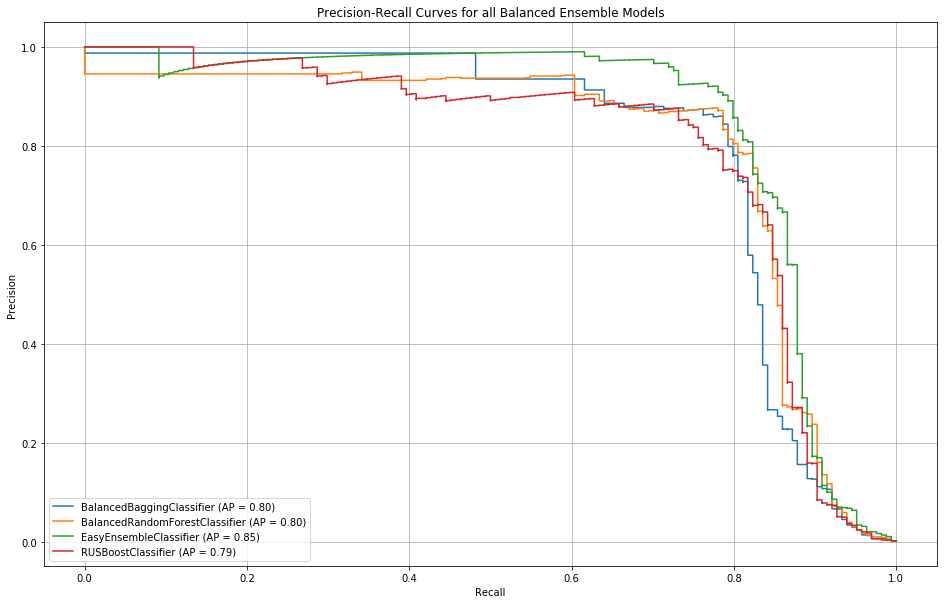

In [38]:
disp_bbc = plot_precision_recall_curve(bbc, X_test, y_test)
disp_brfc = plot_precision_recall_curve(brfc, X_test, y_test, ax=disp_bbc.ax_)
disp_eec = plot_precision_recall_curve(eec, X_test, y_test, ax=disp_bbc.ax_)
disp_rbc = plot_precision_recall_curve(rbc, X_test, y_test, ax=disp_bbc.ax_)
disp_bbc.figure_.set_size_inches(16, 10)
disp_bbc.ax_.set_title('Precision-Recall Curves for all Balanced Ensemble Models')
plt.grid()
plt.show()

#### Observation: 
It is apparent from the comparison of the precision-recall curves that Easy Ensemble Classifier dominates all others for all practical values of desired recall. Therefore, we will make a comparison between EEC and the duo of LGBM and ETC_ADA in the next section.

## Step 6: Conclusion

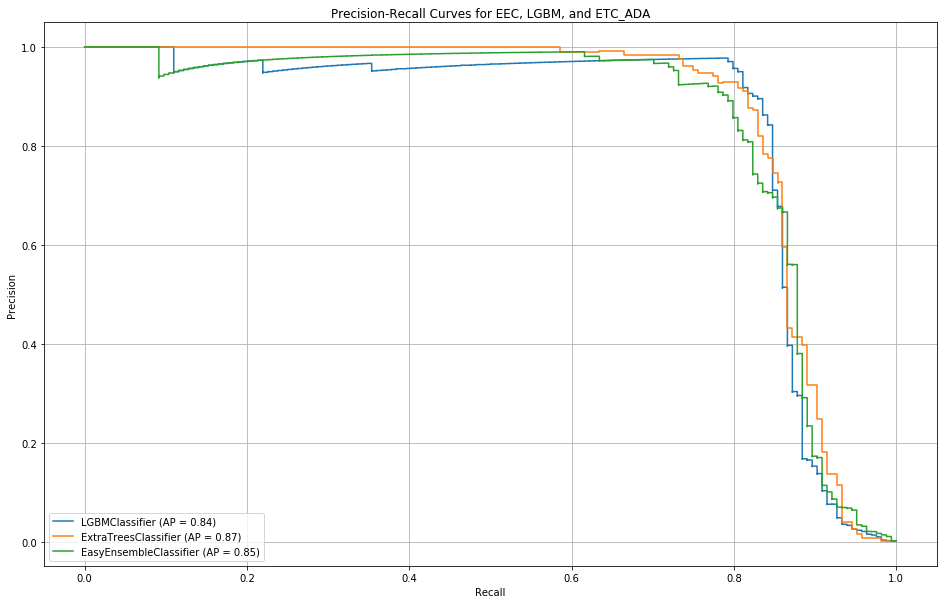

In [39]:
disp_LGBM = plot_precision_recall_curve(LGBM, X_test, y_test)
disp_ETC_ADA = plot_precision_recall_curve(ETC_ADA, X_test, y_test, ax=disp_LGBM.ax_)
disp_eec = plot_precision_recall_curve(eec, X_test, y_test, ax=disp_LGBM.ax_)
disp_LGBM.ax_.set_title('Precision-Recall Curves for EEC, LGBM, and ETC_ADA')
disp_LGBM.figure_.set_size_inches(16, 10)
plt.grid()
plt.show()

LGBM and ETC_ADA duo dominates EEC everywhere along the precision-recall curve except at a very small section with a very small margin; consequently, balanced ensemble methods did not improve the result we achieved in the previous notebook. As a result, LGBM and ETC_ADA in combination is still the best predicitive model we were able to construct so far. 